In [ ]:
!pip install --no-index --no-deps /kaggle/input/lavis-pretrained/salesforce-lavis/transformers* 
!pip install --no-index --no-deps /kaggle/input/lavis-pretrained/salesforce-lavis/hugging*

Processing /kaggle/input/lavis-pretrained/salesforce-lavis/transformers-4.26.1-py3-none-any.whl
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
Processing /kaggle/input/lavis-pretrained/salesforce-lavis/huggingface_hub-0.12.0-py3-none-any.whl
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.31.1
    Uninstalling huggingface-hub-0.31.1:
      Successfully uninstalled huggingface-hub-0.31.1


In [ ]:
# Upgrade Transforemers to the latest version
pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.1 MB/s eta 0:00:00
  Attempting uninstall: hf-xet
    Found existing installation: hf-xet 1.1.0
    Uninstalling hf-xet-1.1.0:
      Successfully uninstalled hf-xet-1.1.0
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Uninstalling huggingface-hub-0.12.0:
      Successfully uninstalled huggingface-hub-0.12.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.26.1
    Uninstalling transformers-4.26.1:
      Successfully uninstalled transformers-4.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you

In [ ]:
# Import essential libraries
# - OS & utilities (os, gc, copy, time, random, joblib)
# - Data manipulation (numpy, pandas)
# - PyTorch modeling (torch, nn, optim, Dataset, DataLoader, etc.)
# - Image handling (PIL), progress bars (tqdm), and default dicts
# - Transformer-based models (transformers, BlipForConditionalGeneration)
# - Colored terminal text for pretty logs (colorama)
# - Suppressing warnings & setting CUDA and tokenizer environment options for stability

import os
import gc
import copy
import time
import random
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoProcessor
from transformers import BlipForConditionalGeneration
from torch.optim import AdamW
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL


import warnings
warnings.filterwarnings("ignore")


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TOKENIZERS_PARALLELISM'] = "False"

2025-06-06 23:01:56.600885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749250917.036329      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749250917.155433      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Config dictionary stores all hyperparameters and settings

CONFIG = {
    "seed": 2023,
    "epochs": 10,
    # This version using BLIP-Base for image captioning
    # It can be upgraded to more powerful large version by changing image-captioning-base to image-captioning-large
    "model_name": "Salesforce/blip-image-captioning-base",
    "train_batch_size": 4,
    "valid_batch_size": 4,
    "learning_rate": 5e-7,  
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 5e-7,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "competition": "SD", 
}

# Load processor from model name
CONFIG["processor"] = AutoProcessor.from_pretrained(CONFIG["model_name"])

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# Set random seeds for reproducibility across numpy, torch, and environment

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [ ]:
import pandas as pd
from PIL import Image
import os

# Function to load images and add them to the dataset
def load_image_and_add_to_dataset(csv_file, image_folder):
    # Read the CSV file containing ECG text descriptions annotated by cardiologists
    df = pd.read_csv(csv_file)
    
    # List to store new data
    data_list = []
    
    # Iterate through the DataFrame and load images
    for index, row in df.iterrows():
        image_path = os.path.join(image_folder, row['image'])
        image = Image.open(image_path)
        data = {
            'image': image,
            'caption': row['caption']
        }
        data_list.append(data)
    
    return data_list

# Paths to the CSV file and the image folder
# If using Kaggle, the CSV file and image folder can be added under Notebook > Input > Add Input (if a Kaggle dataset was created beforehand)
# Or by uploading them directly using Upload
csv_file = "/kaggle/input/14000datas/blipdatasetptbxlengcap_14000.csv"
image_folder = "/kaggle/input/ptb-xl-ecg-processed/PTB-XL ECG Dataset/PTB-XL ECG Dataset"

# Load images and add them to the dataset
Dataset = load_image_and_add_to_dataset(csv_file, image_folder)

# Access the first element of datas
print(Dataset[0])

# Access image information and prompt from the first element
image = Dataset[0]['image']
caption = Dataset[0]['caption']
print("Caption:", caption)
print("Image:", image)

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CA93C5C1310>, 'caption': 'sinus rhythm with incomplete right bundle branch block otherwise normal ecg'}
Caption: sinus rhythm with incomplete right bundle branch block otherwise normal ecg
Image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7CA93C5C1310>


In [8]:
Dataset[6]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'caption': 'sinus arrhythmia left type av block 2nd degree intraventricular conduction disturbance i v1 t changes high t in v2 3 ecg pathological'}

In [9]:
Dataset[2]["caption"]

'premature ventricular contractions atrial fibrillation st-segments are depressed in i avl t-waves are low or flat in limb leads and v4 v5 v6 findings are likely to be due to ischemic heart disease and digitalis effect'

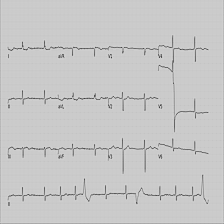

In [10]:
Dataset[2]["image"]

In [ ]:
# Split the data into train, validation, and test sets: 80% train, 10% val, 10% test

from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(Dataset, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
# Print the number of samples in the train, validation, and test sets
print(len(train_df))
print(len(val_df))
print(len(test_df))

11200
1400
1400


In [ ]:
# Save the test data (specifically the text descriptions) to a new CSV file
# The file will be saved to Kaggle Working, so it can be downloaded directly (Output section)
csv_data_list = []

for item in test_df:
    image_path = os.path.basename(item['image'].filename)
    caption = item['caption']
    csv_data_list.append({'caption': caption, 'image': image_path})

csv_df = pd.DataFrame(csv_data_list)

csv_file_path = 'Test_Dataset_BLIP-ECG-14000.csv'
csv_df.to_csv(csv_file_path, index=False)

print(f"Test_Dataset_BLIP-ECG telah disimpan di {csv_file_path}")

Test_Dataset_BLIP-ECG telah disimpan di Test_Dataset_BLIP-ECG-14000.csv


In [ ]:
# This custom dataset class prepares image-caption pairs by processing them into tensors suitable for the BLIP model

from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["caption"], 
                                  padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [15]:
train_dataset = ImageCaptioningDataset(train_df, CONFIG['processor'])
valid_dataset = ImageCaptioningDataset(val_df, CONFIG['processor'])

In [16]:
train_dataset[0].keys()

dict_keys(['pixel_values', 'input_ids', 'attention_mask'])

In [ ]:
# This line loads the BLIP model (for generating captions) with pretrained weights specified by
model = BlipForConditionalGeneration.from_pretrained(CONFIG['model_name'])

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
# Function to setting the model to training mode
# Feeding batches of images and captions through the model
# Computing the loss and performing backpropagation
# Updating the optimizer (and learning rate scheduler) every n_accumulate steps for gradient accumulation

from tqdm import tqdm
tracking and displaying the running average loss and current learning rate with a progress bar

def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        input_ids = data['input_ids'].to(device)
        pixel_values = data['pixel_values'].to(device)
        
        batch_size = input_ids.size(0)

        outputs = model(input_ids=input_ids, 
                        pixel_values=pixel_values, 
                        labels=input_ids)
                
        loss = outputs.loss
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    
    # Cleaning up GPU memory to avoid out-of-memory issues
    gc.collect()
    torch.cuda.empty_cache()
    
    return epoch_loss

In [ ]:
# This function evaluates model performance on validation data by calculating and reporting the average loss, without training or backpropagation.

from tqdm import tqdm

@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        input_ids = data['input_ids'].to(device)
        pixel_values = data['pixel_values'].to(device)
        
        batch_size = input_ids.size(0)

        outputs = model(input_ids=input_ids, 
                        pixel_values=pixel_values, 
                        labels=input_ids)
                
        loss = outputs.loss
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return epoch_loss

In [ ]:
# This function runs the complete training process with progress tracking, model saving, and automatic best-model restoration

def run_training(model, optimizer, scheduler, device, num_epochs, train_loader, valid_loader):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        train_epoch_loss = train_one_epoch(
            model, optimizer, scheduler, 
            dataloader=train_loader, 
            device=device, 
            epoch=epoch
        )
        
        val_epoch_loss = valid_one_epoch(
            model, valid_loader, 
            device=device, 
            epoch=epoch
        )
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
        print(f"Epoch {epoch} -> Train Loss: {train_epoch_loss:.4f} | Valid Loss: {val_epoch_loss:.4f}")
        
        # Save the best model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss:.4f} ---> {val_epoch_loss:.4f})")
            best_epoch_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "BestLoss.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model saved to {PATH}{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 60)
    ))
    print(f"Best Loss: {best_epoch_loss:.4f}")
    
    # Load the best model weights before returning
    model.load_state_dict(best_model_wts)
    
    return model, history

In [ ]:
# This function picks and initializes the scheduler based on the config so the learning rate adjusts properly during training

def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [ ]:
# This part ties everything together
# Prepares data loaders, trains the model, saves it, and confirms the save by printing the working directory contents

# Create Dataloaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=CONFIG['train_batch_size'])
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=CONFIG['valid_batch_size'])

model.to(CONFIG['device'])

# Define Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

model, history = run_training(
    model, optimizer, scheduler,
    device=CONFIG['device'],
    num_epochs=CONFIG['epochs'],
    train_loader=train_loader,
    valid_loader=valid_loader
)

# Save the model in Kaggle working directory
save_path = 'blip-ecg-base-10epoch-14000.pth'
torch.save(model.state_dict(), save_path)
print(f"Training finished and model saved as {save_path}")

# List files in working directory to confirm save
print("Files in working directory:", os.listdir('.'))

[INFO] Using GPU: Tesla T4




  0%|          | 0/2800 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.

100%|██████████| 350/350 [02:43<00:00,  2.14it/s, Epoch=1, Valid_Loss=2.18]


Epoch 1 -> Train Loss: 5.3274 | Valid Loss: 2.1791
Validation Loss Improved (inf ---> 2.1791)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:41<00:00,  2.17it/s, Epoch=2, Valid_Loss=0.242]


Epoch 2 -> Train Loss: 0.8765 | Valid Loss: 0.2425
Validation Loss Improved (2.1791 ---> 0.2425)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:41<00:00,  2.16it/s, Epoch=3, Valid_Loss=0.0881]


Epoch 3 -> Train Loss: 0.1431 | Valid Loss: 0.0881
Validation Loss Improved (0.2425 ---> 0.0881)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:42<00:00,  2.16it/s, Epoch=4, Valid_Loss=0.0564]


Epoch 4 -> Train Loss: 0.0691 | Valid Loss: 0.0564
Validation Loss Improved (0.0881 ---> 0.0564)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:41<00:00,  2.17it/s, Epoch=5, Valid_Loss=0.0464]


Epoch 5 -> Train Loss: 0.0511 | Valid Loss: 0.0464
Validation Loss Improved (0.0564 ---> 0.0464)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:41<00:00,  2.17it/s, Epoch=6, Valid_Loss=0.0424]


Epoch 6 -> Train Loss: 0.0442 | Valid Loss: 0.0424
Validation Loss Improved (0.0464 ---> 0.0424)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:43<00:00,  2.14it/s, Epoch=7, Valid_Loss=0.0407]


Epoch 7 -> Train Loss: 0.0405 | Valid Loss: 0.0407
Validation Loss Improved (0.0424 ---> 0.0407)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:43<00:00,  2.14it/s, Epoch=8, Valid_Loss=0.0392]


Epoch 8 -> Train Loss: 0.0381 | Valid Loss: 0.0392
Validation Loss Improved (0.0407 ---> 0.0392)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:42<00:00,  2.15it/s, Epoch=9, Valid_Loss=0.0374]


Epoch 9 -> Train Loss: 0.0365 | Valid Loss: 0.0374
Validation Loss Improved (0.0392 ---> 0.0374)
Model saved to BestLoss.bin



100%|██████████| 350/350 [02:41<00:00,  2.17it/s, Epoch=10, Valid_Loss=0.0365]


Epoch 10 -> Train Loss: 0.0347 | Valid Loss: 0.0365
Validation Loss Improved (0.0374 ---> 0.0365)
Model saved to BestLoss.bin

Training complete in 10h 42m 49s
Best Loss: 0.0365
Training finished and model saved as blip-ecg-base-10epoch-14000.pth
Files in working directory: ['BestLoss.bin', 'Test_Dataset_BLIP-ECG-14000.csv', '__notebook__.ipynb', 'blip-ecg-base-10epoch-14000.pth']


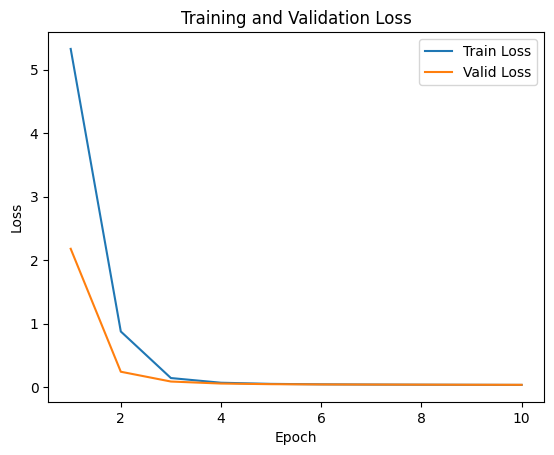

In [ ]:
# Create a loss-vs-epoch chart so it’s easy to see if the model is learning or overfitting.

import matplotlib.pyplot as plt

plt.plot(range(1, CONFIG['epochs'] + 1), history['Train Loss'], label='Train Loss')
plt.plot(range(1, CONFIG['epochs'] + 1), history['Valid Loss'], label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import torch
import os

# New path to save the model (use Kaggle working)
model_output_path = '/kaggle/working/blip-ecg-capt-14000-10epoch.pth'

# Save the model
torch.save(model.state_dict(), model_output_path)
print(f"Model berhasil disimpan di {model_output_path}")

# Check the contents of the working directory for confirmation
print("Isi direktori kerja saat ini:")
for file in os.listdir('/kaggle/working'):
    print("-", file)

Model berhasil disimpan di /kaggle/working/blip-ecg-capt-14000-10epoch.pth
Isi direktori kerja saat ini:
- BestLoss.bin
- blip-ecg-capt-14000-10epoch.pth
- Test_Dataset_BLIP-ECG-14000.csv
- __notebook__.ipynb
- blip-ecg-base-10epoch-14000.pth
